In [1]:
import numpy as np #Import relevant packages
import pandas as pd
import math
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
import glob
import csv
import matplotlib.pyplot as plt

In [2]:
def unpack_data(filepath): #Returns a dictionary where each item is a df containing one run. One dict per generation.
    all_files = glob.glob(filepath + "/*.csv")
    name_list = []
    datadict = {}
    for f in all_files:
        name_list.append(f[77:-4])
    for i,n in enumerate(name_list):
        datadict[n] = pd.read_csv(all_files[i], header=0)
    for k, v in datadict.items():
        v.drop(columns=["Unnamed: 0", "volume", "spread", "10_MA", "50_MA"], inplace=True)
    return datadict

def format_data(datadict, window): #Turn dictionaries of data into features and samples lists
    x_data = []
    y_data = []
    for k, v in datadict.items():
        for i in range(len(v)):
            if i >= window:
                y_data.append(v.iloc[i]["trading_price"])
                xi = v.iloc[i-window:i].to_numpy()
                x_data.append(xi)
    x_data = np.array(x_data)
    y_data = np.array(y_data)
    y_data = np.reshape(y_data, (y_data.shape[0], 1))
    return x_data, y_data

def normalise_data(xarray, yarray): #Take the natural log and then normalise prices
    yarray_log = np.log(yarray)
    xarray_log = np.log(xarray)
    xsc = StandardScaler()
    instances, timesteps, features = xarray_log.shape
    xarray_log = np.reshape(xarray_log, (-1, features))
    xarray_norm = xsc.fit_transform(xarray_log)
    xarray_norm = np.reshape(xarray_norm, (instances, timesteps, features))
    ysc = StandardScaler().fit(yarray_log)
    yarray_norm = ysc.transform(yarray_log)
    return xarray_norm, yarray_norm, xsc, ysc

def split_data(xarray, yarray, trainratio): #Split the data into training and test sets
    train_len = int(len(xarray)*trainratio)
    test_len = len(xarray) - train_len
    x_train, y_train, x_test, y_test = xarray[:train_len], yarray[:train_len], xarray[train_len:], yarray[train_len:]
    return x_train, y_train, x_test, y_test

In [3]:
gen1 = unpack_data("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/gen1_sims/data")

In [32]:
X2, y2 = format_data(gen1, 20)

In [33]:
#print(X2)
#print(y2)

In [34]:
X2_train, y2_train, X2_test, y2_test = split_data(X2, y2, 0.8)

In [35]:
X2_train, y2_train, X2scale, y2scale = normalise_data(X2_train, y2_train)
X2_test, y2_test, _, _ = normalise_data(X2_test, y2_test)

In [36]:
print(X2scale.mean_)
print(X2scale.var_)
print(y2scale.mean_)
print(y2scale.var_)
#print(X2_train)
#print(y2_train)

[4.7065291  4.78767914]
[0.05321885 0.01509073]
[4.71154396]
[0.05840521]


In [37]:
lstm2=keras.Sequential() #Set up the architecture of the model

lstm2.add(layers.LSTM(units=16, input_shape=(X2_train.shape[1], X2_train.shape[2])))
lstm2.add(layers.Dropout(0.2))

lstm2.add(layers.Dense(units=1))

In [38]:
#print(lstm2.summary())

In [39]:
lstm2.compile(optimizer='nadam', loss='mean_squared_error') #Compile and train the model

history2 = lstm2.fit(X2_train, y2_train, epochs = 10, batch_size = 32, validation_split=0.2, shuffle=False)

Train on 18024 samples, validate on 4506 samples
Epoch 1/10
18024/18024 [==============================] - 42s 2ms/sample - loss: 0.2460 - val_loss: 0.0068
Epoch 2/10
18024/18024 [==============================] - 26s 1ms/sample - loss: 0.0642 - val_loss: 0.0041
Epoch 3/10
18024/18024 [==============================] - 25s 1ms/sample - loss: 0.0429 - val_loss: 0.0030
Epoch 4/10
18024/18024 [==============================] - 27s 2ms/sample - loss: 0.0343 - val_loss: 0.0069
Epoch 5/10
18024/18024 [==============================] - 22s 1ms/sample - loss: 0.0273 - val_loss: 0.0022
Epoch 6/10
18024/18024 [==============================] - 25s 1ms/sample - loss: 0.0240 - val_loss: 0.0017
Epoch 7/10
18024/18024 [==============================] - 29s 2ms/sample - loss: 0.0239 - val_loss: 0.0029
Epoch 8/10
18024/18024 [==============================] - 34s 2ms/sample - loss: 0.0214 - val_loss: 0.0029
Epoch 9/10
18024/18024 [==============================] - 29s 2ms/sample - loss: 0.0209 - val_l

In [40]:
lstm2.save("/Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm2")

INFO:tensorflow:Assets written to: /Users/karangarg/Documents/Year 3 Modules/EC331/Code/rae_repo/lstms/lstm2/assets


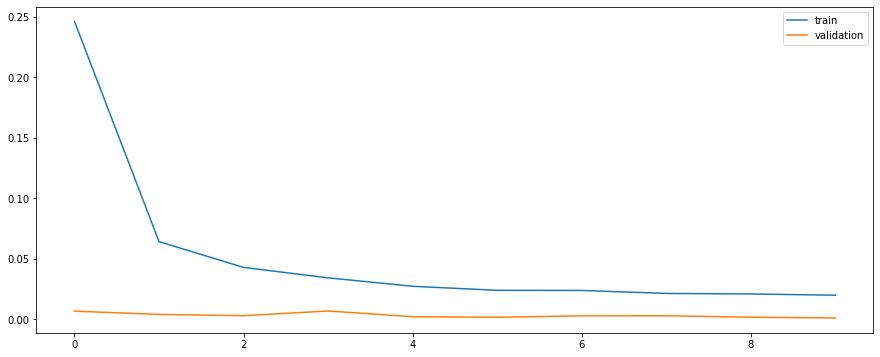

In [44]:
plt.figure(figsize=(15,6))
plt.plot(history2.history["loss"], label="train")
plt.plot(history2.history["val_loss"], label="validation")
plt.legend()

In [42]:
y2_pred = lstm2.predict(X2_test)
y2_train_inv = y2scale.inverse_transform(y2_train.reshape(1, -1))
y2_test_inv = y2scale.inverse_transform(y2_test.reshape(1, -1))
y2_pred_inv  = y2scale.inverse_transform(y2_pred)

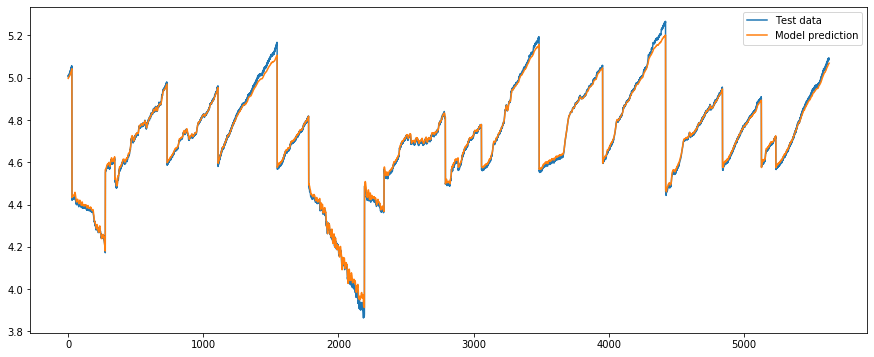

In [45]:
plt.figure(figsize=(15,6))
plt.plot(y2_test_inv.flatten(), label="Test data")
plt.plot(y2_pred_inv.flatten(), label="Model prediction")
plt.legend()